In [1]:
%load_ext tikzmagic
%matplotlib inline

# 부분회귀와 비선형회귀분석

지금까지는 예측값이 직선형태로 나오는 선형(linear)회귀분석을 이용하여 종속변수를 예측하였다. 그러나 현실의 데이터는 이러한 선형회귀분석 모형을 따르지 않을 수도 있다. 이 절에서는 선형회귀분석 모형이 적절하지 않은 경우를 찾아내고 이런 경우에 어떤 방식으로 모형을 수정해야하는지를 공부한다.

## 부분회귀

독립변수가 하나뿐인 경우에는 x축을 독립변수로, y축을 종속변수로 하는 스캐터플롯과 예측값 직선을 이용하여 회귀분석의 결과를 시각적으로 표시하여 독립변수와 종속변수의 관계 및 회귀 성능을 유추할 수 있었다. 하지만 독립변수가 두개 이상인 경우에 이러한 방식을 사용하면 다른 독립변수의 영향으로 예측값이 직선으로 나오지 않기 때문에 이러한 시각화 방식을 사용하기 어렵다. 

보스턴 집값 데이터를 lstat과 rm 두가지 독립변수로 선형회귀분석한 결과를 이용하여 예를 들어보자. 

In [1]:
import statsmodels.api as sm

boston = sm.datasets.get_rdataset("Boston", "MASS").data
model2 = sm.OLS.from_formula("medv ~ scale(lstat) + scale(rm)", boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     444.3
Date:                Tue, 02 Aug 2022   Prob (F-statistic):          7.01e-112
Time:                        10:24:26   Log-Likelihood:                -1582.8
No. Observations:                 506   AIC:                             3172.
Df Residuals:                     503   BIC:                             3184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.5328      0.246     91.487   

예를 들어 x축을 두번째 독립변수인 rm으로, y축을 종속변수인 medv로 놓고 2차원 평면에 데이터(o)와 예측값(x)을 그리면 다음과 같다. 이 플롯으로는 독립변수 lstat에 대한 모형의 가중치(기울기)를 알 수가 없다.

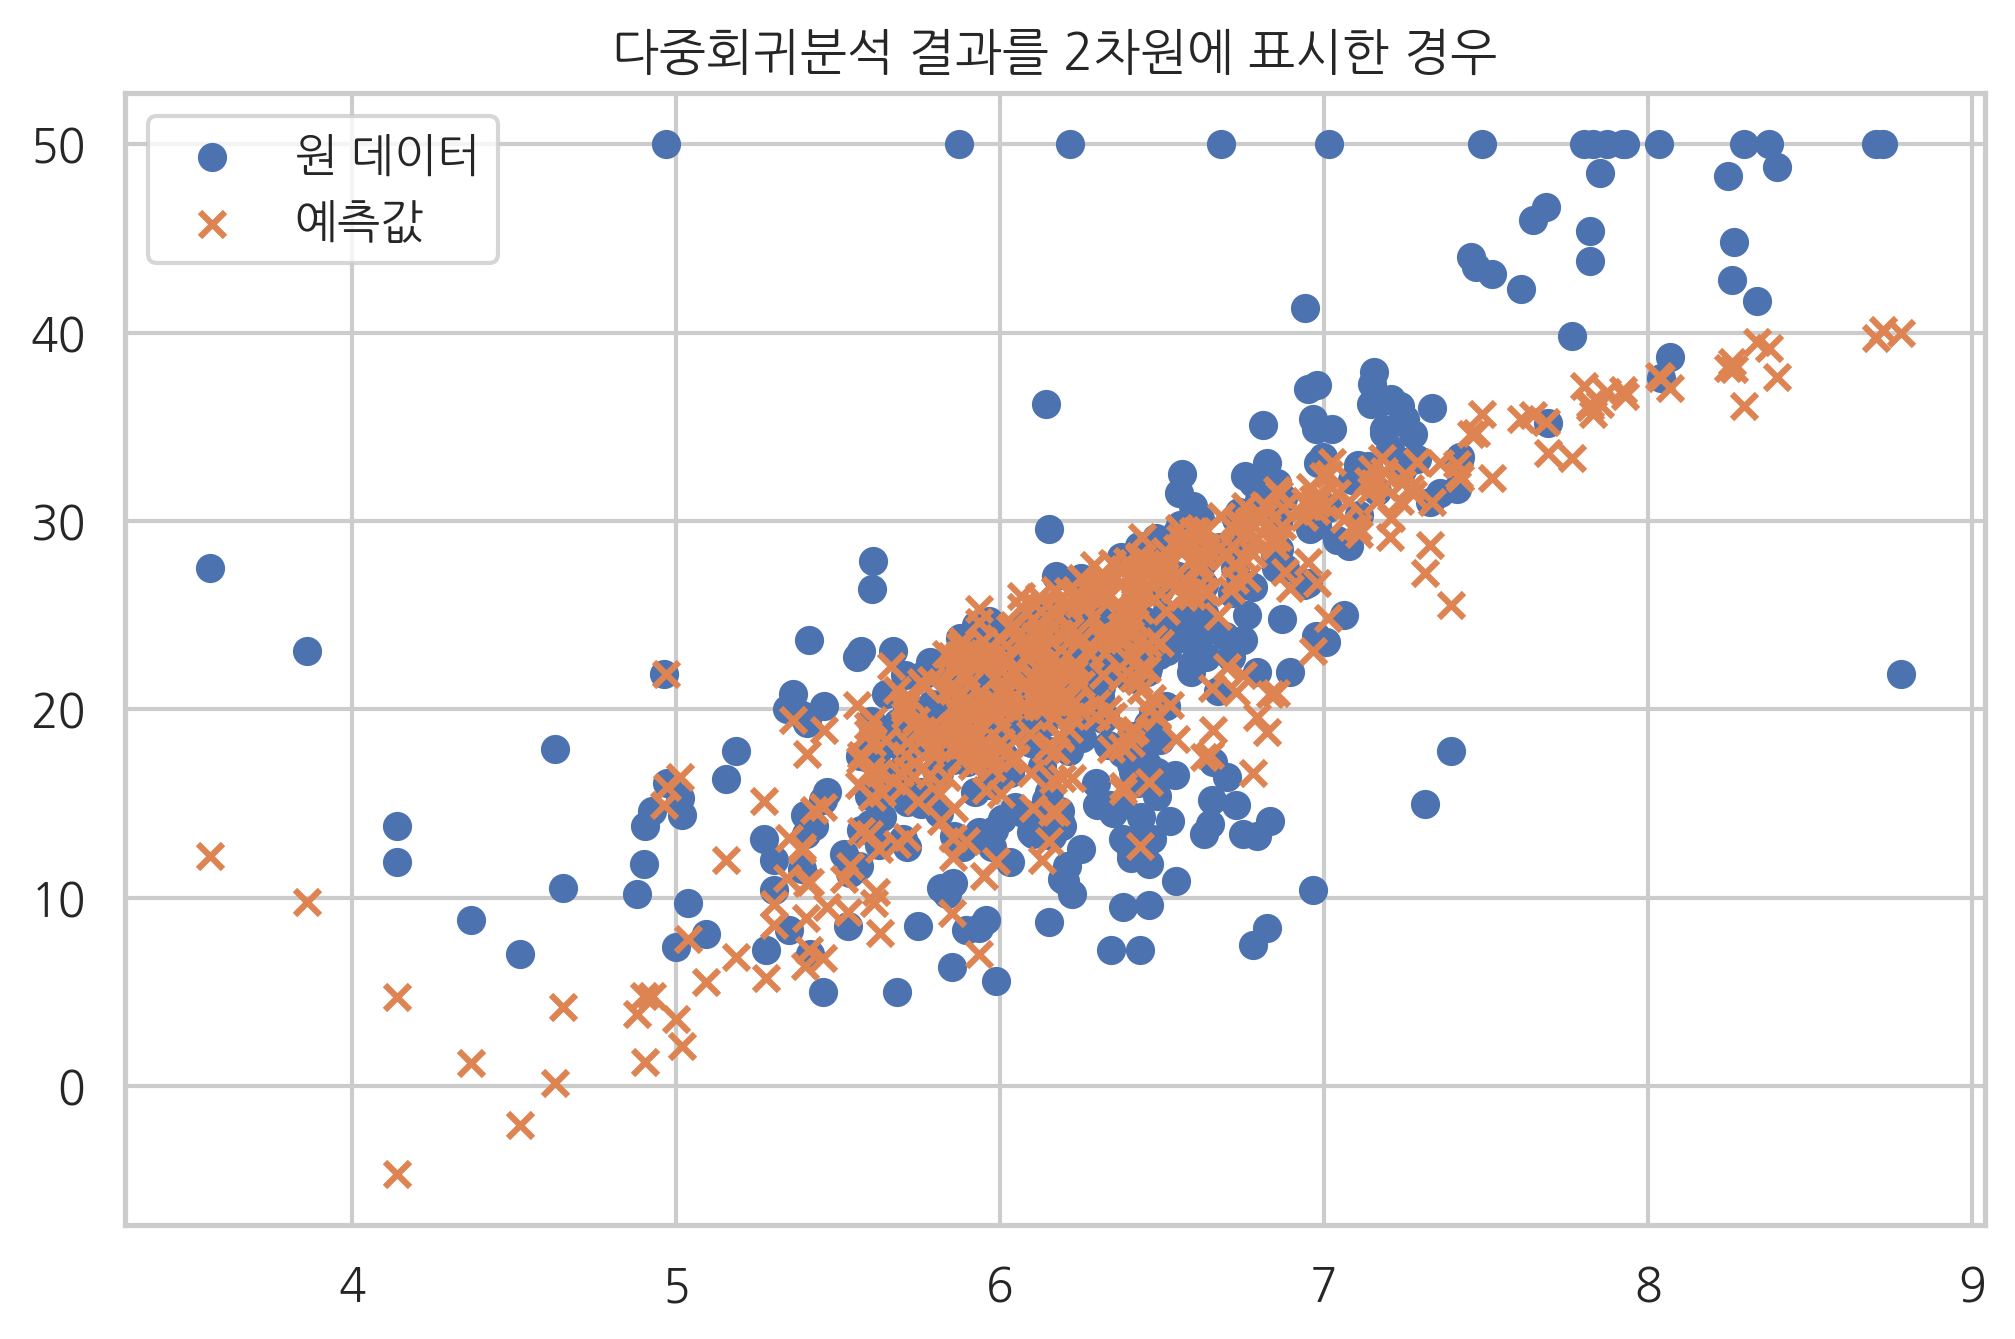

In [14]:
x = boston.rm
y = boston.medv
y_hat = result2.fittedvalues

plt.scatter(x, y, marker="o", label="원 데이터")
plt.scatter(x, y_hat, marker="x", label="예측값")
plt.legend()
plt.title("다중회귀분석 결과를 2차원에 표시한 경우")
plt.show()

이러한 경우에 사용할 수 있는 방법이 CCPR(component-plus-residual) 및 부분회귀(partial-regression) 시각화 방법이다. 

<b>CCPR(component-plus-residual)</b> 시각화는 2차원 평면에서 x축을 특정한 독립변수 하나, 예를 들어 $k$번째 독립변수인 $x_k$ 값으로 놓고 y축은 다음 데이터를 이용한다.

* 원 데이터의 y축 값으로는 

$$
\hat{y}_k = w_k x_k + e
$$

를 사용한다. 여기에서 $e$는 전체 독립변수를 사용한 다중선형회귀분석 결과에서 나온 잔차다.

* 예측 데이터의 y축 값으로는 선형회귀 예측값에서 $x_k$과 관련된 부분인

$$
\hat{y}_k = w_k x_k 
$$

만 사용한다. 이렇게 하면 다중선형회귀분석의 결과로 나온 가중치의 값(기울기)도 표시하고 그에 따른 오차도 표시된다.

statsmodels 패키지는 CCPR 시각화를 위한 `plot_ccpr` 함수를 제공한다. 사용법은 다음과 같다.

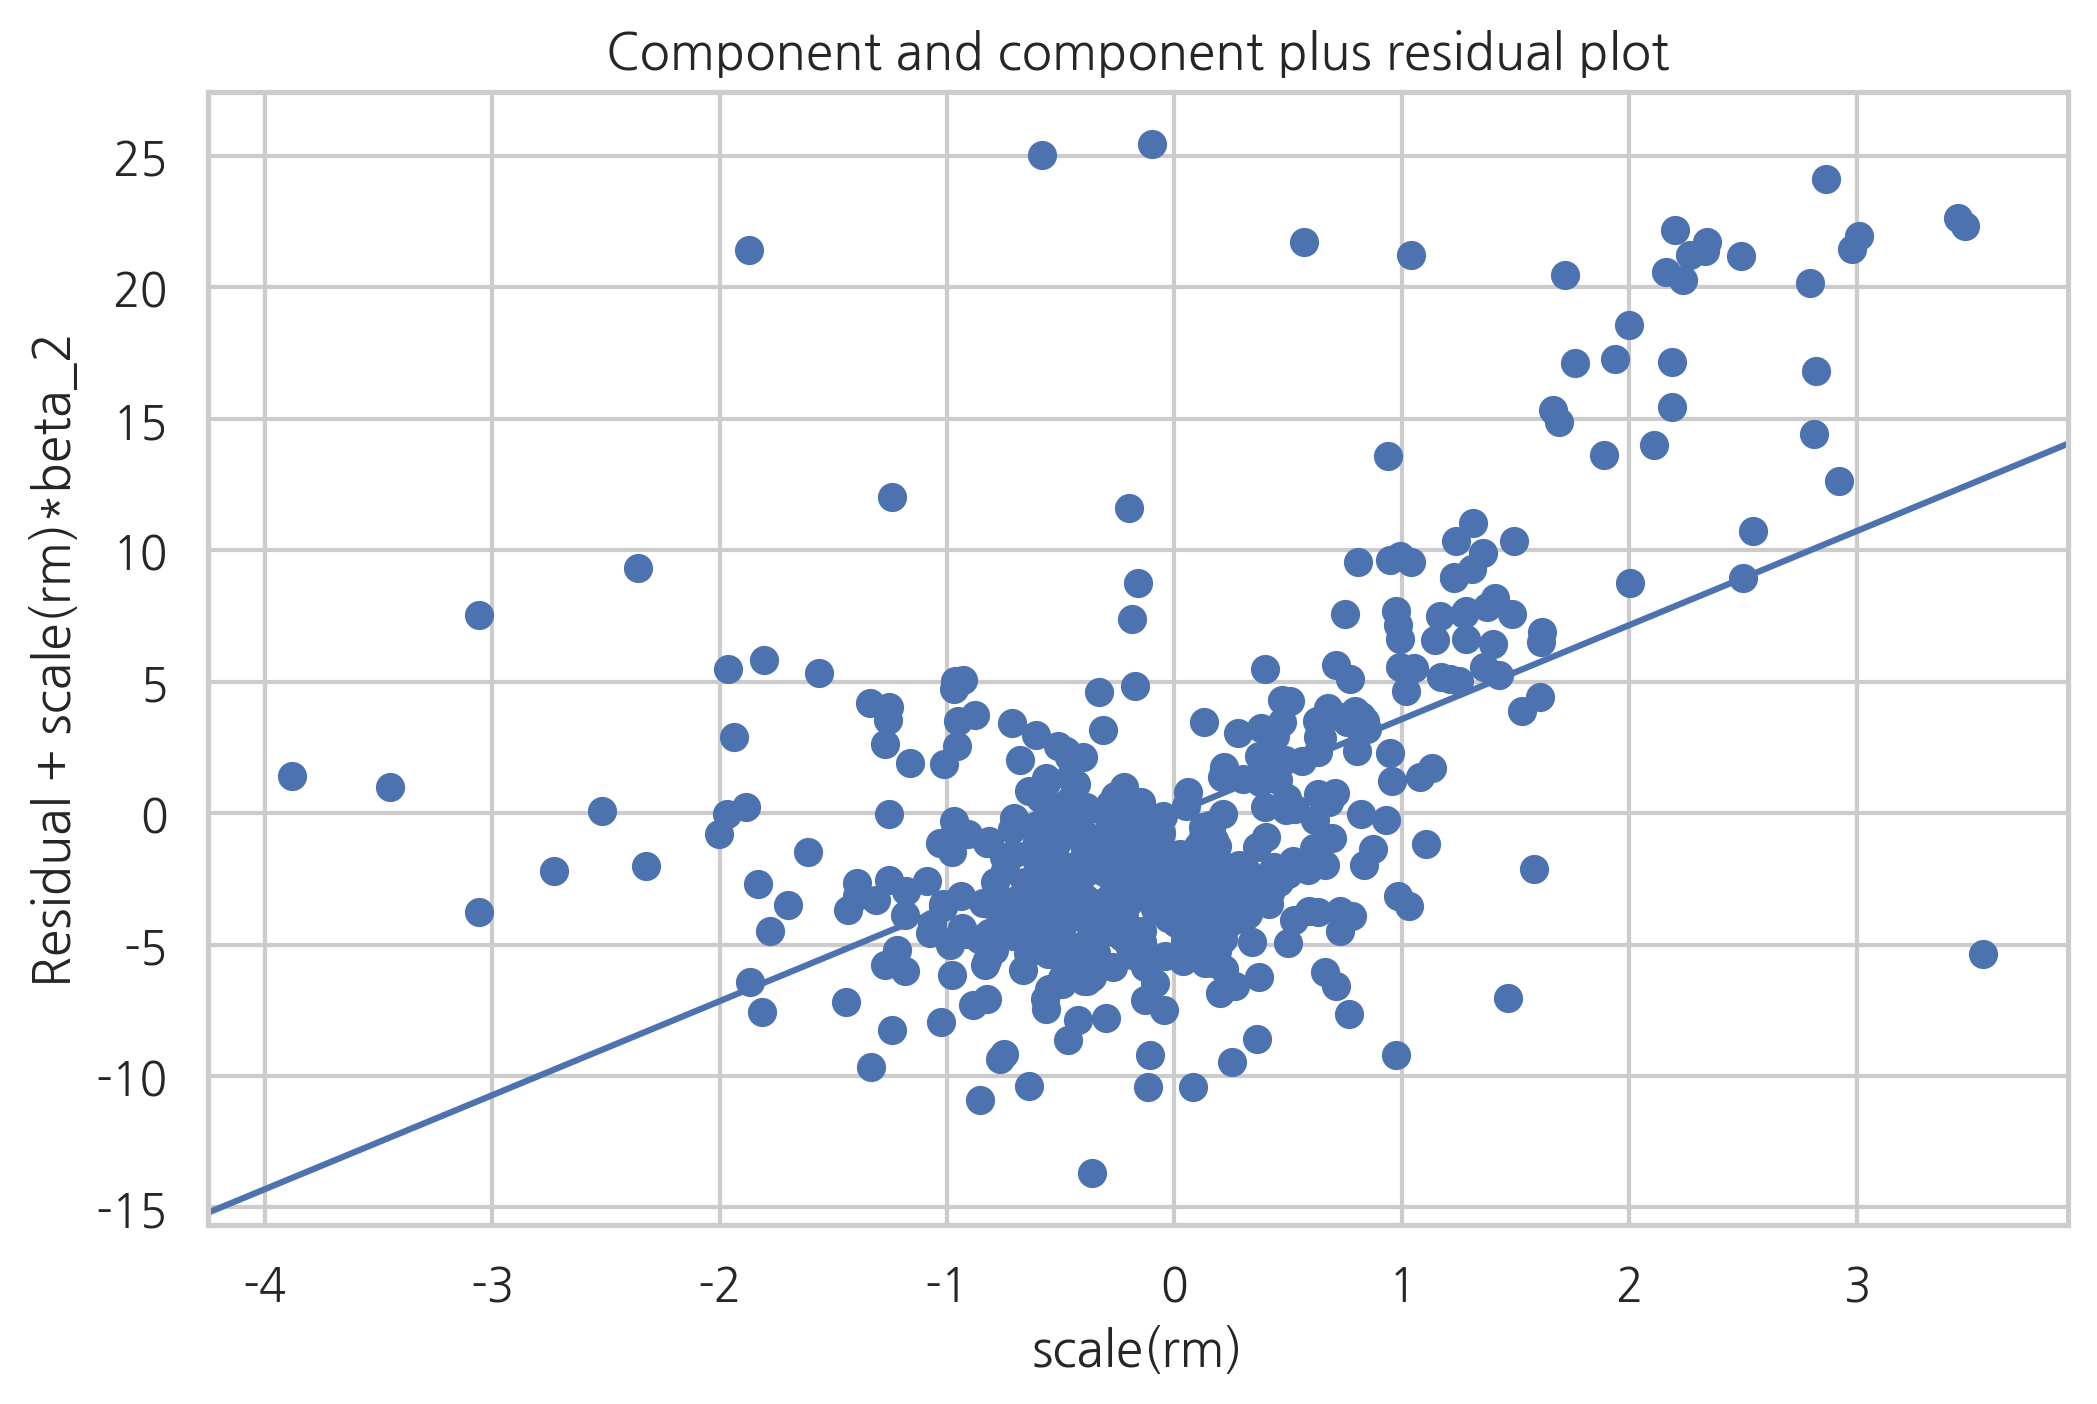

In [15]:
sm.graphics.plot_ccpr(result2, 'scale(rm)')
plt.show()

또다른 방법은 부분회귀 방법을 사용하는 것이다. <b>부분회귀(partial regression)</b>는 특정한 독립변수 $x_k$과 종속변수 $y$만의 관계만 분석하고 $x_k$를 제외한 다른 독립변수의 영향은 제거하는 방법이다. 부분회귀를 하려면 원리적으로 다음과 같이 3번의 회귀분석을 해야 한다.

1. 특정한 독립변수 $x_k$를 제외한 나머지 독립변수들로 종속변수 $y$를 선형회귀분석하여 잔차 $y_k^{\ast}$를 구한다.
1. 특정한 독립변수 $x_k$를 제외한 나머지 독립변수들로 특정한 독립변수 $x_k$를 선형회귀분석하여 잔차 $x_k^{\ast}$를 구한다.
1. 잔차 $x_k^{\ast}$를 독립변수로, 잔차 $y_k^{\ast}$를 종속변수로 하여 선형회귀분석한다.

예를 들어 첫번째 독립변수인 $x_1$과 종속변수 $y$만의 관계만 구하고 싶은 경우, 1번 작업을 통해 $x_1$을 제외한 $x_2, x_3, \ldots, x_k$만 사용하여 선형회귀분석을 한다. 그러면 이 때 나오는 잔차 $y_k^{\ast}$는 독립변수 $x_2, x_3, \ldots, x_k$로는 도저히 예측할 수 없는 부분만 남는다. 그리고 2번 작업을 통해 $x_1$ 정보 중 $x_2, x_3, \ldots, x_k$와 상관관계가 있는 값을 제거하여 순수한 $x_1$ 정보만을 남긴다. 마지막으로 3번 작업을 통해 순수한 $x_1$ 정보와 $x_2, x_3, \ldots, x_k$로 예측 불가능한 정보 사이의 관계를 구하는 것이다. 이러한 방식으로 부분회귀를 하면 3번 작업에서 나온 가중치 $\hat{w}_k$가 모든 독립변수를 사용하였을 때 나오는 가중치 $\hat{w}_k$와 일치함을 수학적으로 증명할 수 있다.

statsmodels 패키지는 부분회귀 시각화를 위한 `plot_partregress` 함수를 제공한다. 이 함수를 사용할 때는 다음과 같은 인수를 넣어야 한다.

1. 종속변수의 이름 문자열
1. 분석하고자 하는 특정 독립변수의 이름 문자열
1. 분석하고자 하는 특정 독립변수를 제외한 나머지 독립변수들의 이름 문자열 리스트
1. 데이터프레임
1. `obs_labels`: 각 데이터에 라벨을 그리는 경우 `True`, 아니면 `False`

함수를 실행하면 x축에는 잔차 $x_k^{\ast}$를, y축에는 잔차 $y_k^{\ast}$를 스케터플롯으로 그리고 가중치 $\hat{w}_k$를 사용한 선형회귀 결과를 직선으로 표시한다.

eval_env: 1


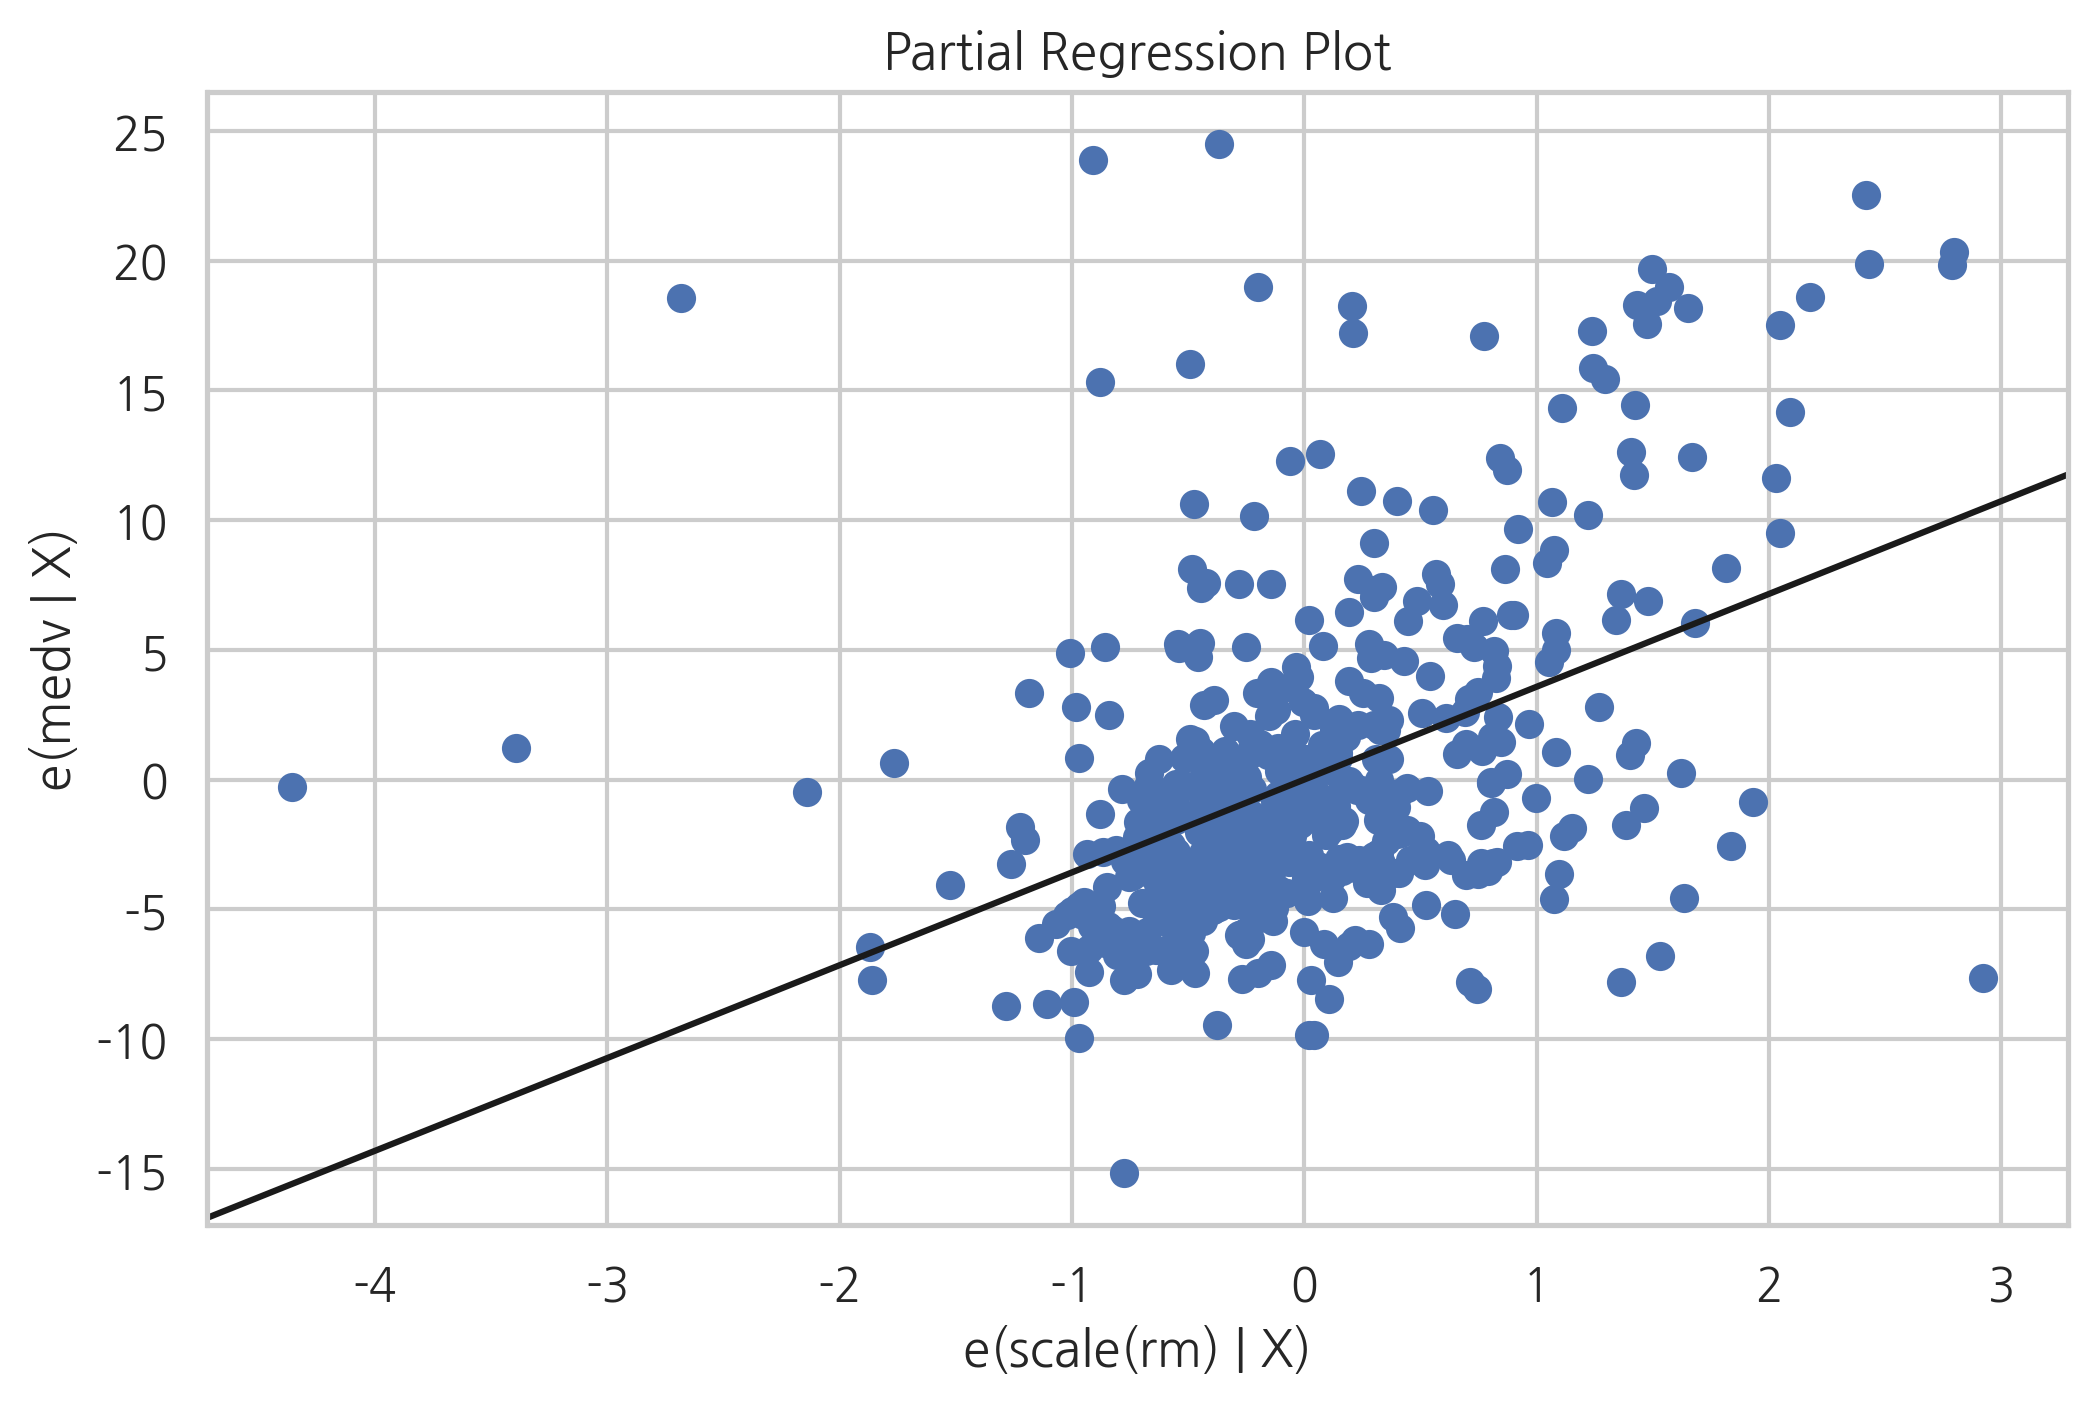

In [17]:
sm.graphics.plot_partregress('medv', 'scale(rm)', ["scale(lstat)"], boston, obs_labels=False)
plt.show()

`plot_regress_exog` 함수를 이용하면 CCPR과 부분회귀 결과를 동시에 그릴 수 있다.

eval_env: 1


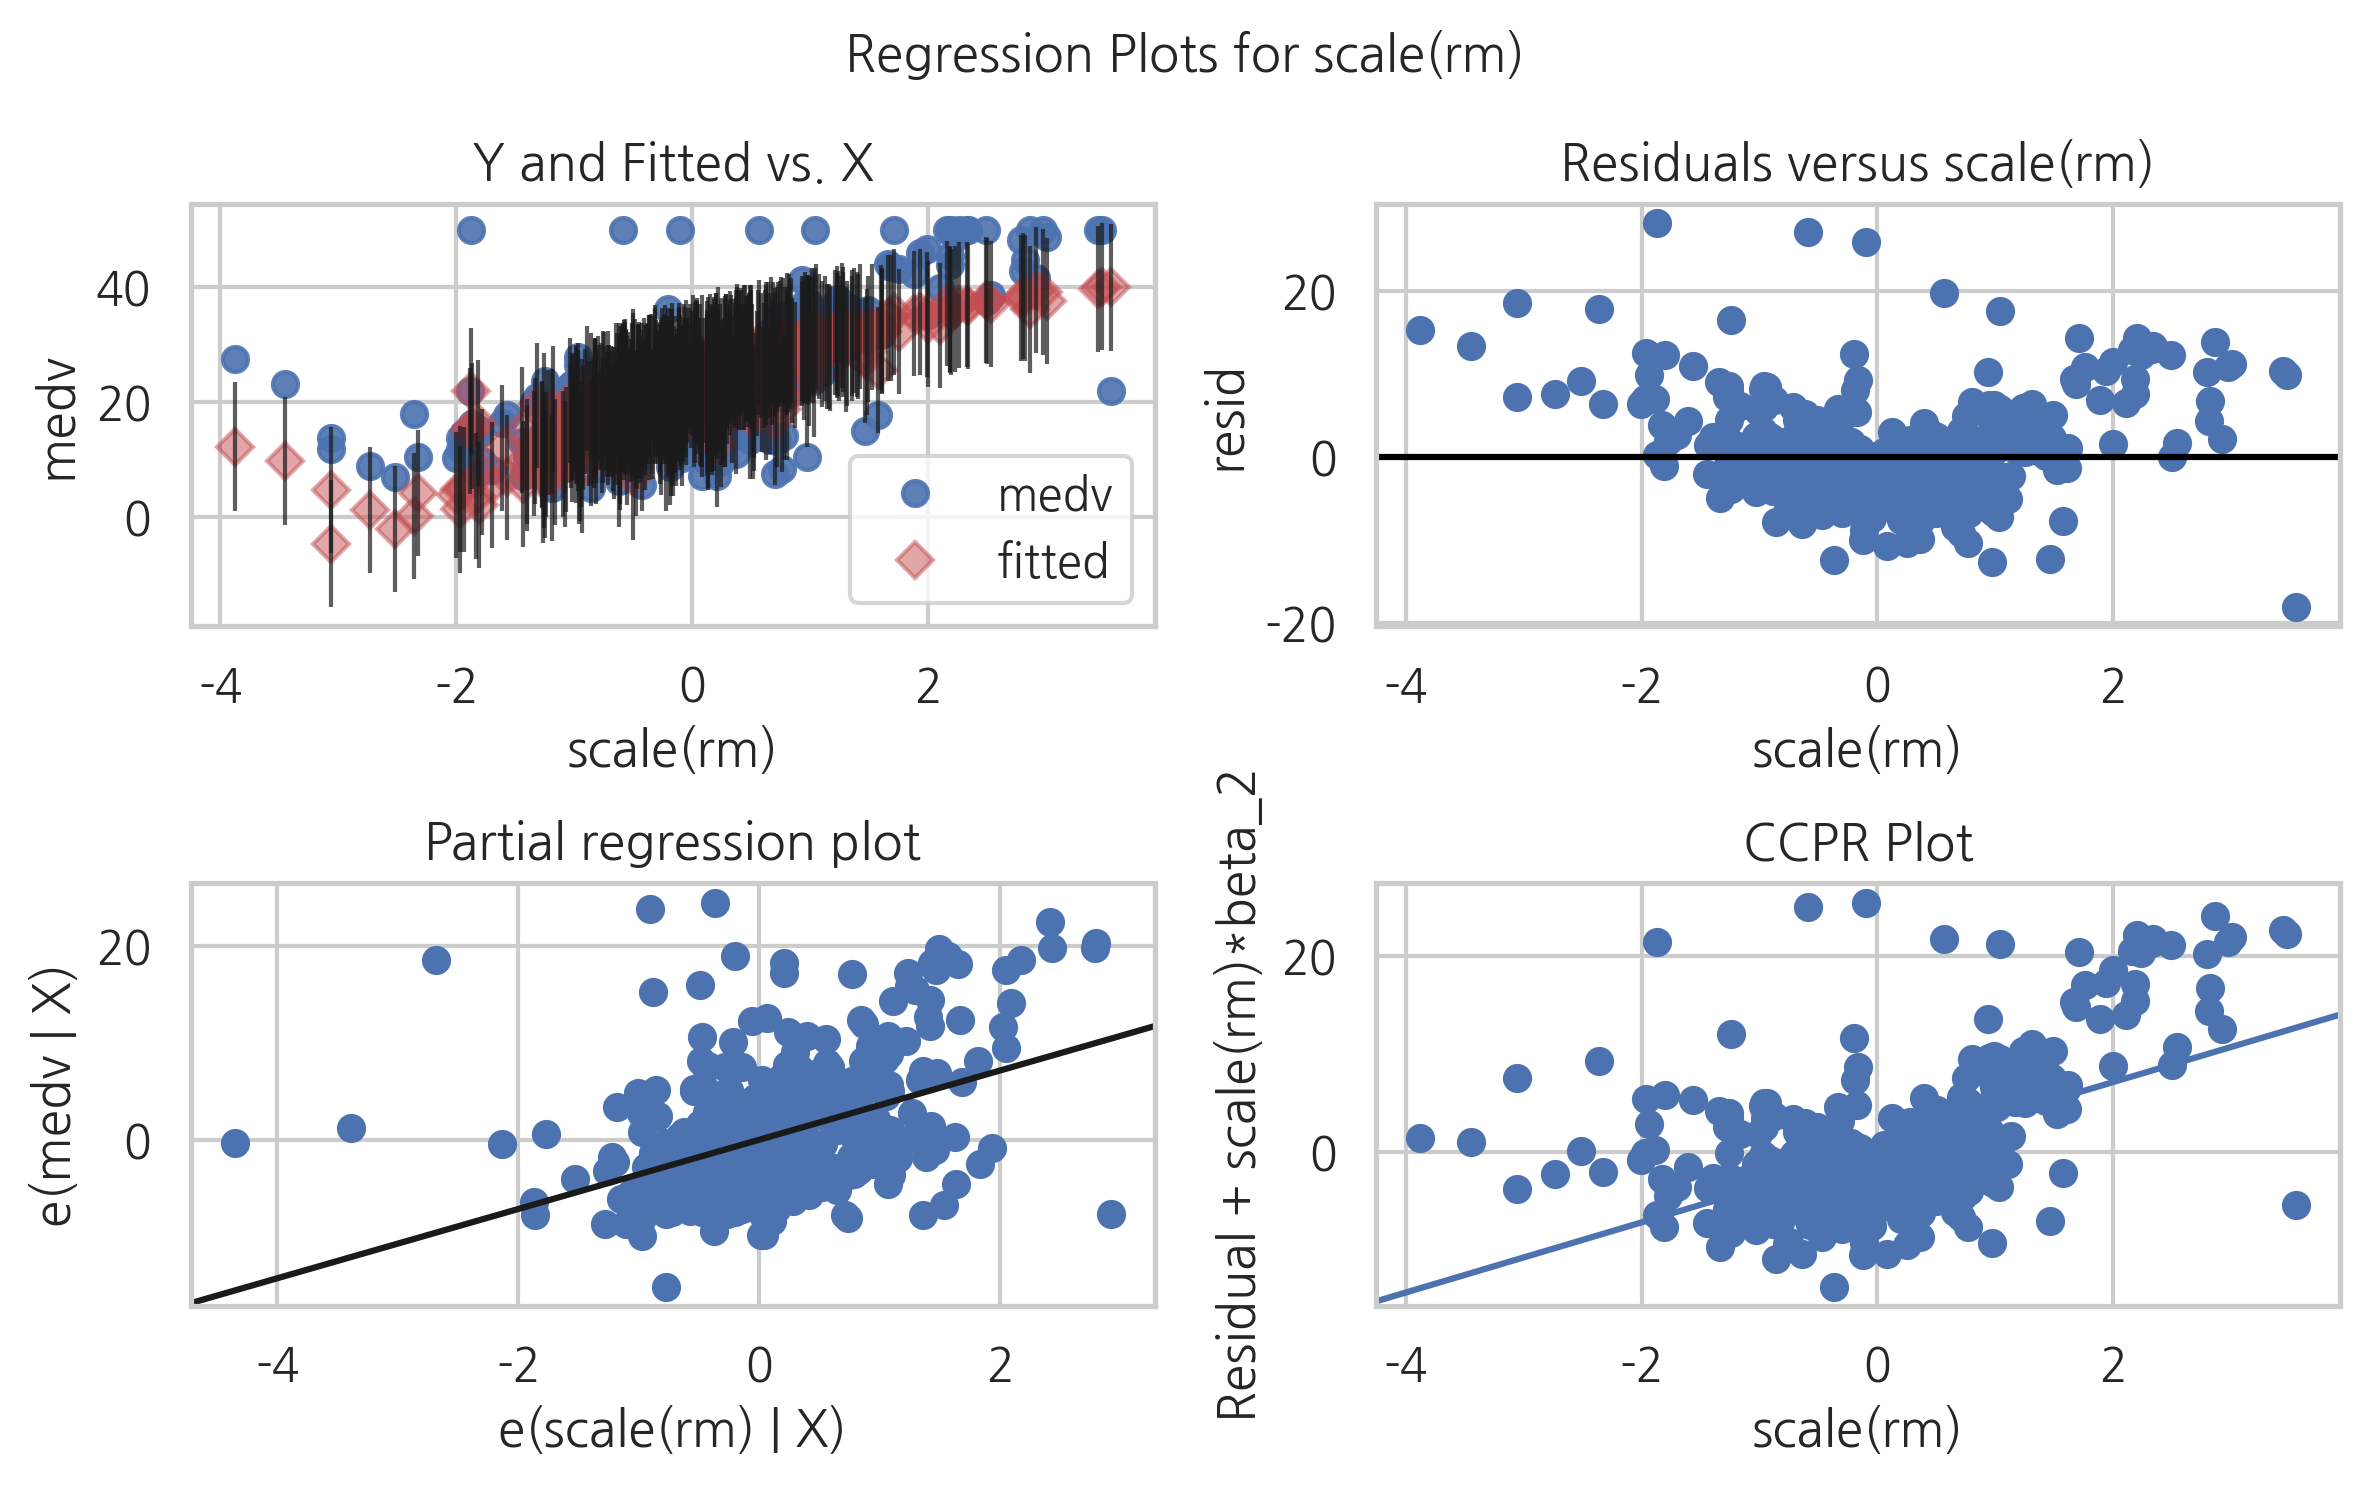

In [20]:
sm.graphics.plot_regress_exog(result2, "scale(rm)")
plt.tight_layout()
plt.show()

상단 왼쪽의 그림은 우리가 처음에 그렸던 독립변수와 잔차 그대로 스캐터플롯한 결과다. 상단 오른쪽의 그림은 독립변수와 전체 선형회귀분석 잔차를 그린 것이다. 하단은 부분회귀와 CCPR 결과다.

## 비선형회귀분석

## 다항회귀

## 심볼 탐색